In [1]:
import os, torch
os.chdir("/Users/ESKO/PYWORK/NHITS")
print(os.getcwd())

C:\Users\ESKO\anaconda3\envs\dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\ESKO\PYWORK\NHITS


In [2]:
torch.cuda.is_available()

True

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.auto import NHITS, AutoTFT
from neuralforecast.models import LSTM, NHITS, RNN
from neuralforecast.core import NeuralForecast
from neuralforecast.losses.pytorch import MAE
from neuralforecast.losses.numpy import mse, mae, mape

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [242]:
df_2021 = pd.read_csv('./data/metal_pst.csv')
df_2022 = pd.read_csv('./data/metal_pst.csv')

df_2021.rename(columns={'date':'ds'},inplace=True)
df_2021.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df_2021['ds'] = pd.to_datetime(df_2021['ds'], format='%Y-%m-%d')
df_2021 = df_2021[df_2021.ds<='2021-12-31']

df_2022.rename(columns={'date':'ds'},inplace=True)
df_2022.rename(columns={'li2co3_cif_fast_kg_spot_exchng':'y'},inplace=True)
df_2022['ds'] = pd.to_datetime(df_2022['ds'], format='%Y-%m-%d')

df_ftr_2023 = pd.read_csv('./data/metal_ftr_2023.csv')
df_ftr_2023.rename(columns={'date':'ds'},inplace=True)
df_ftr_2023['ds'] = pd.to_datetime(df_ftr_2023['ds'], format='%Y-%m-%d')

static_df = pd.read_csv('./data/static_df.csv')

df_pst_list = pd.read_csv('./data/metal_pst_list.csv',encoding='cp949')
df_pst_list = df_pst_list.loc[0:].values.flatten().tolist()

df_combined_list = df_2022.columns[:3].values.flatten().tolist() + df_pst_list
df_combined_2022 = df_2022[df_combined_list]
# df_combined.to_csv('./data/df_combined.csv',encoding='cp949',index=False)

In [243]:
df_combined

,ds,unique_id,y,중국 니켈 SEMIS 수입량,미국 생산자물가지수,광물종합지수,원면 [브라질(수출가 FOB)] 현물,옥수수 For Grain [미국(생산자 가격)] 현물,커피 Arabicas [미국/유럽] 현물,WTI [CME(NYMEX)] 2022.12,...,미국 근원소비자물가지수,탄화규소 88% 0-10mm [중국(FOB)] 현물,소맥 Durum [미국(생산자 가격)] 현물,Howe Robinson Container Index,대두박 [파라나구아(FOB)] 현물,보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물,GDP_SAU,HOUSECOST_KOR,PPP_POL,PPP_SRB
0,2016-01-31,A,20.177268,1.034156e+06,190.80,1000.000000,1485.8,366,116.389000,35.590833,...,244.96,626.500000,660,449.75,288.59,4410.588235,7.956615e+05,99.330737,1.765116,40.737336
1,2016-02-29,A,23.306868,7.048700e+05,189.40,1041.302857,1489.0,357,117.662381,35.630556,...,245.51,636.250000,597,447.75,280.90,4410.588235,7.956615e+05,99.330737,1.765116,40.737336
2,2016-03-31,A,25.223010,1.209299e+06,189.80,1108.910952,1475.3,357,125.736364,41.162609,...,245.91,625.217391,604,449.00,273.32,4410.588235,7.956615e+05,99.330737,1.765116,40.737336
3,2016-04-30,A,25.308243,1.231497e+06,190.40,1124.755238,1451.5,358,123.245714,43.524286,...,246.55,598.000000,624,443.00,292.83,4410.588235,7.956615e+05,99.812751,1.765116,40.737336
4,2016-05-31,A,24.875099,1.055474e+06,191.10,1111.572000,1433.8,368,124.253636,48.280455,...,247.14,595.000000,657,447.00,385.40,4410.588235,7.956615e+05,99.812751,1.765116,40.737336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2022-08-31,A,73.000000,2.568106e+09,252.21,3293.093478,1977.3,724,221.901304,89.384348,...,296.95,1229.565217,1080,4966.00,511.88,6175.000000,1.751178e+06,110.597566,1.823305,42.392183
80,2022-09-30,A,74.047619,2.568106e+09,253.19,3218.095455,2037.6,709,219.593182,81.817143,...,298.66,1172.500000,992,3445.00,518.49,6166.190476,1.751178e+06,110.597566,1.823305,42.392183
81,2022-10-31,A,77.673913,2.568106e+09,255.90,3164.617143,2095.5,650,192.267619,83.310000,...,299.47,1091.000000,1020,1836.25,483.03,6243.333333,1.751178e+06,112.082983,1.823305,42.392183
82,2022-11-30,A,80.818182,2.568106e+09,256.46,3184.678182,1958.6,650,166.537727,82.577143,...,300.07,1070.909091,1020,1489.00,475.71,5979.545455,1.751178e+06,112.082983,1.823305,42.392183


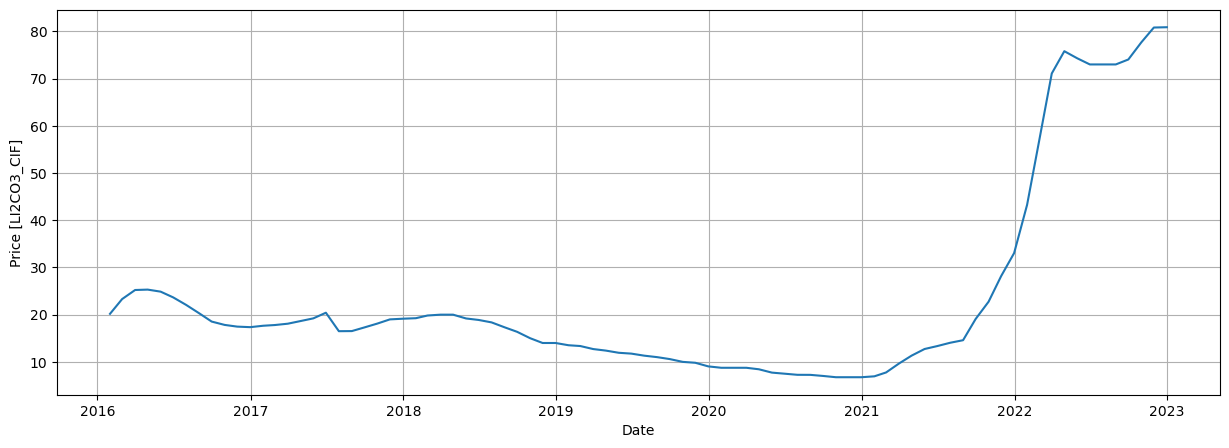

In [199]:
plt.figure(figsize=(15,5))
plt.plot(df_2022['ds'], df_2022['y'])
plt.xlabel('Date')
plt.ylabel('Price [LI2CO3_CIF]')
plt.grid()

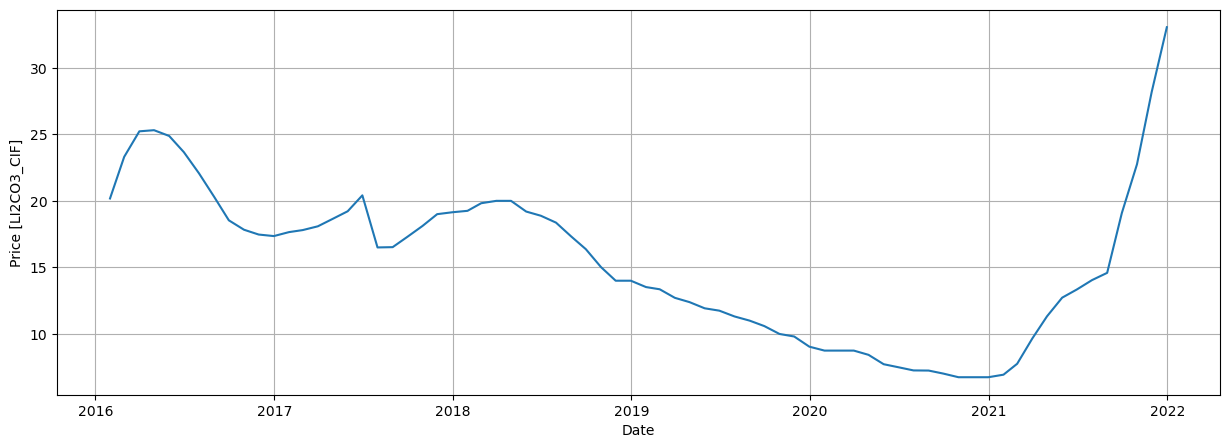

In [200]:
plt.figure(figsize=(15,5))
plt.plot(df_2021['ds'], df_2021['y'])
plt.xlabel('Date')
plt.ylabel('Price [LI2CO3_CIF]')
plt.grid()

In [84]:
# Y_train_df = df_combined[df_combined.ds<='2021-12-31']
# Y_test_df = df_combined[df_combined.ds>'2021-12-31']

# Fit and predict with N-BEATS and N-HiTS models
# horizon = len(Y_test_df)

In [201]:
df_pst_list

['중국 니켈 SEMIS 수입량',
 '미국 생산자물가지수',
 '광물종합지수',
 '원면 [브라질(수출가 FOB)] 현물',
 '옥수수 For Grain [미국(생산자 가격)] 현물',
 '커피 Arabicas [미국/유럽] 현물',
 'WTI [CME(NYMEX)] 2022.12',
 '미국 소비자물가지수',
 '대두유 crude and refined average price [파라나구아(FOB)] 현물',
 '대두 [미국(생산자 가격)] 현물',
 '미국 근원소비자물가지수',
 '탄화규소 88% 0-10mm [중국(FOB)] 현물',
 '소맥 Durum [미국(생산자 가격)] 현물',
 'Howe Robinson Container Index',
 '대두박 [파라나구아(FOB)] 현물',
 '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물',
 'GDP_SAU',
 'HOUSECOST_KOR',
 'PPP_POL',
 'PPP_SRB']

In [237]:
horizon = 12
models = [
          # LSTM(h=horizon,                    
          #      gpus=1,
          #      max_epochs=500,
          #      hist_exog_list = df_combined.columns[4:].values.flatten().tolist(),
          #      futr_exog_list = df2.columns[2:].values.flatten().tolist(),
          #      # hist_exog_list = df.columns[4:].values.flatten().tolist(),
          #      scaler_type='robust',       # Type of scaler to normalize data
          #      encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
          #      decoder_hidden_size=64,),
          # AutoTFT(h=horizon,
          #         gpus=1,
          #         loss=MAE(),
          #         config=None,
          #         # futr_exog_list = df2.columns[2:].values.flatten().tolist(),
          #         # hist_exog_list = df_combined.columns[1:].values.flatten().tolist(),
          #         num_samples=12),
          NHITS(h = horizon,
                gpus=1,
                input_size = 2*horizon,
                hist_exog_list = df_combined_2022.columns[4:].values.flatten().tolist(),
                futr_exog_list = [
                                  'Shanghai Containerized Freight Index (SCFI)'
                                  # '대두 [미국(생산자 가격)] 현물',
                                  # '대두유 crude and refined average price [파라나구아(FOB)] 현물',
                                  '보일러용 후판 Q245R 30mm Xinyu Steel [중국] 현물'
                                  # 'HOUSECOST_KOR'
                                 ],
                # hist_exog_list = df.columns[4:].values.flatten().tolist(),
                max_steps=100,
                # stat_exog_list =
                scaler_type = 'standard')]

In [238]:
# df_2022.columns[4:].values.flatten().tolist()

In [239]:
%%time
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=df_2022, static_df=static_df)

Epoch 0:  50%|███████████████               | 1/2 [00:00<00:00,  3.22it/s, loss=3.23, v_num=444, train_loss_step=3.230]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███   | 1/2 [00:00<00:00, 20.00it/s, loss=3.11, v_num=444, train_loss_step=2.990, train_loss_epoch=3.230]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███   | 1/2 [00:00<00:00, 20.19it/s, loss=2.95, v_num=444, train_loss_step=2.630, train_loss_epoch=2.990]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███▌   | 1/2 [00:00<00:00, 18.47it/s, loss=2.9, v_num=444, train_loss_step=2.760, train_loss_epoch=2.630]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███   | 1/2 [00:00<00:00, 18.49it/s, loss=2.78, v_num=444, train_loss_step=2.270, train_loss_epoch=2.760]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███   | 1/2 [00:00<00:00, 21.72it/s, loss=2.62, v_num=444, train_loss_step=1.820, train_loss_epoch=2.270]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███   | 1/2 [00:00<00:00, 18.52it/s, loss=2.45, v_num=444, train_loss_step=1.430

In [240]:
futr_df = pd.read_csv('./data/metal_ftr_2023.csv')
futr_df.rename(columns={'date':'ds'},inplace=True)
futr_df['ds'] = pd.to_datetime(futr_df['ds'], format='%Y-%m-%d')

Y_hat_df = nf.predict(futr_df=futr_df)
Y_hat_df

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.00it/s]


,ds,NHITS
unique_id,,
A,2023-01-31,81.669189
A,2023-02-28,78.503372
A,2023-03-31,76.308731
A,2023-04-30,74.752014
A,2023-05-31,71.641525
A,2023-06-30,68.930984
A,2023-07-31,66.062721
A,2023-08-31,62.111984
A,2023-09-30,57.766396


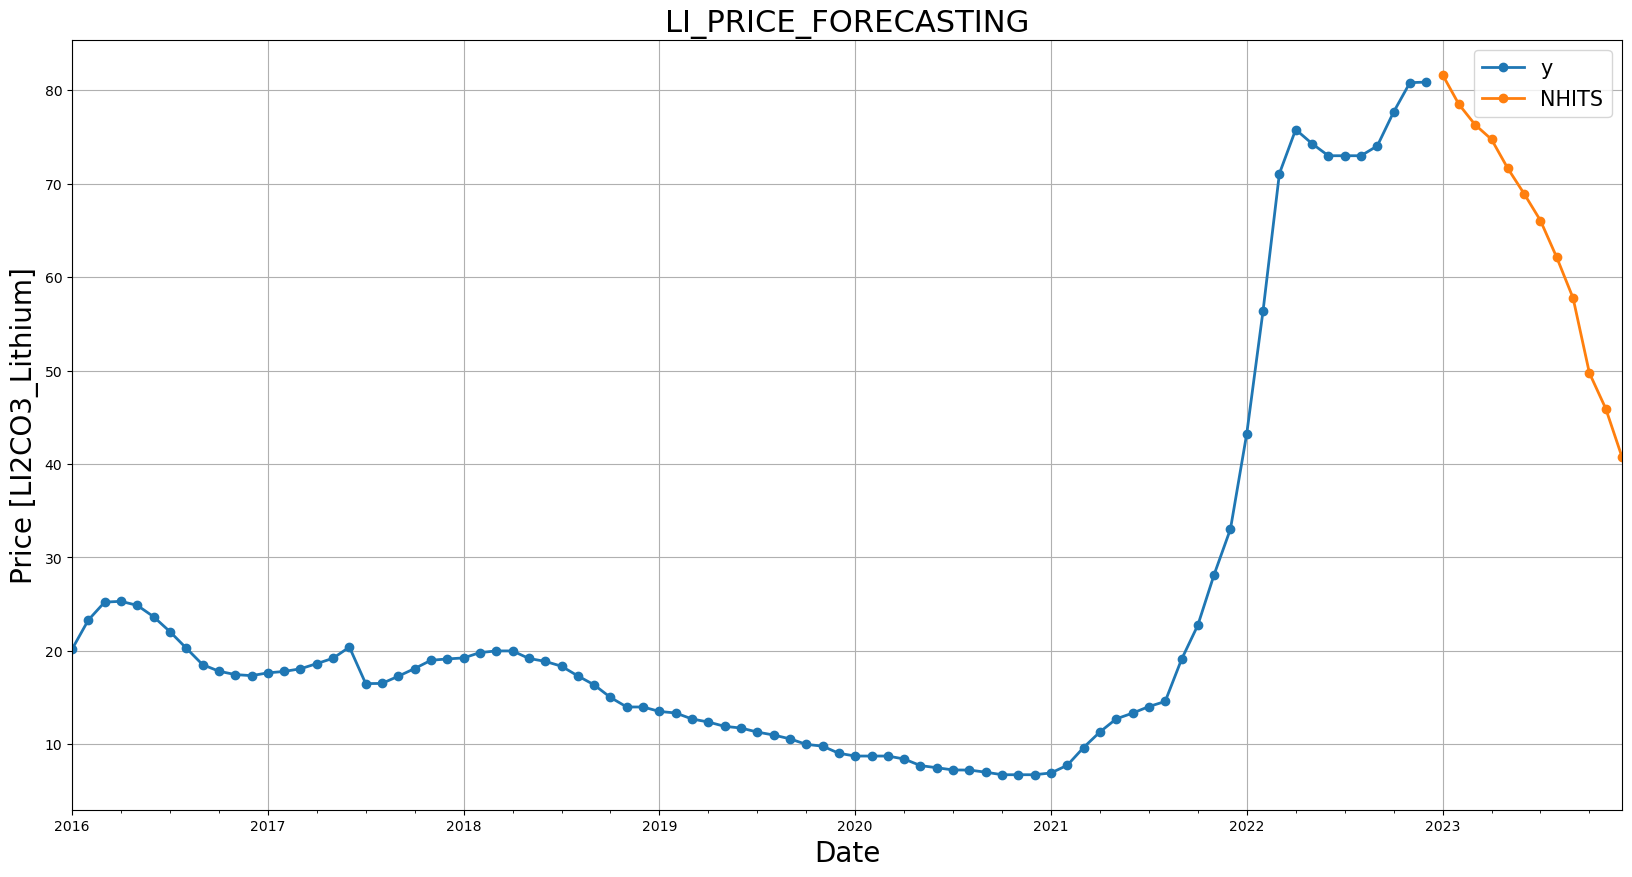

In [244]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))
plot_df = df_2022.reset_index(drop=True)
plot_df2 = pd.concat([plot_df, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df2[['y', 'NHITS']].plot(ax=ax, linewidth=2, marker = 'o')

ax.set_title('LI_PRICE_FORECASTING', fontsize=22)
ax.set_ylabel('Price [LI2CO3_Lithium]', fontsize=20)
ax.set_xlabel('Date', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()